# Lesson 15 - Autoencoders

[Course Repo](https://github.com/fastai/course22p2)

Goal - create a convolutional autoencoder to compress and decompress images. 

First step is to look at convolutional layers. Notebook : [07_convolutions.ipynb](https://github.com/fastai/course22p2/blob/master/nbs/07_convolutions.ipynb).  As always I will copy over the relevant code to this notebook as I work through it.

*NOTE* the video for this section is 1 hour and 37 minutes long, so we will obviously just be hitting the highlights in our discussion!

## Convolutional Layers

### Setup

In [1]:
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

# Note my spelling is different due to an earlier typo... miniai -> minai
from minai.training import *
from minai.datasets import *
import torch.nn.functional as F

### Aside on local libraries

* Note that we import minai.training an minai.datasets. `minai` is a local package defined in the minai directory. 

* Note the empty `__init__.py` file in that directory. This is necessary to make Python treat the directory as a package.  

* We can install this using `pip install -e .` in the root of the course repo. (This makes what is called an "editable install" which means that if you edit the code in the package, you don't need to reinstall it.)


In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

mpl.rcParams['image.cmap'] = 'gray'
mpl.rcParams['figure.dpi'] = 100

In [3]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

* Convolutions are a kind of filter that can be applied to an image, to detect patterns in the image.

* We covered this in some detail in **lesson 8** so I plan to skim over some of the repetition, only highlighting a few things of interest.

* They express a kind of 'inductive bias' that is useful for image data: that is we expect pixels that are close to each other to be related in some way, so we encode this idea in the architecture of the model which reduces the number of parameters needed to learn.


### Sample image

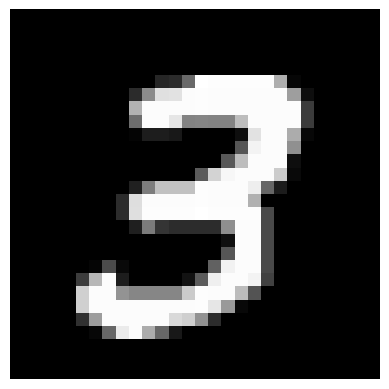

In [4]:
x_imgs = x_train.view(-1,28,28) # view() is similar to reshape() in numpy
xv_imgs = x_valid.view(-1,28,28)
im3 = x_imgs[7]
show_image(im3);


* Recall : Convolutions proceed by sliding a kernal (filter) over the image, multiplying the values in the kernal by the values in the image (dot product), and summing the result.
* We can create kernals to detect different edges. Here we use 3x3 kernals
* Note that in the end we do not put these in manually, we let the model learn them.

In [5]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()


### Multiple Kernels and pytorch.

We can have multiple kernels to detect multiple patterns in the image.



In [6]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

4 output channels, 1 input channel, 3x3 kernel.

Let's get a batch of images

In [7]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

I am skipping over the python implementation. See video for more on that .

One can recognize though that since this is a elementwise multiplication followed by a sum, we should be able to express it as matrix multiplication!   Basic idea is unfold the image into a matrix whrere each column is the elements that should be multiplied by the (flattend) kernal.  Pytorch has a function called `F.unfold` to accomplish this.  

In [8]:
# create a  tensor with each element numbered in order
# Unfold expects the data to have shape (batch, channel, height, width) 
grid = torch.arange(16).view(1,1,4,4).float()
grid

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [9]:
unfolded = F.unfold(grid, (2,2))
unfolded.shape

torch.Size([1, 4, 9])

The result is a batch of matrices, each column represets the elements that should be multiplied by the kernal in each spot as we convolve accross the image.  We can then multiply this by the flattened kernal to get the result of the convolution.

In [10]:
unfolded

tensor([[[ 0.,  1.,  2.,  4.,  5.,  6.,  8.,  9., 10.],
         [ 1.,  2.,  3.,  5.,  6.,  7.,  9., 10., 11.],
         [ 4.,  5.,  6.,  8.,  9., 10., 12., 13., 14.],
         [ 5.,  6.,  7.,  9., 10., 11., 13., 14., 15.]]])

<Axes: >

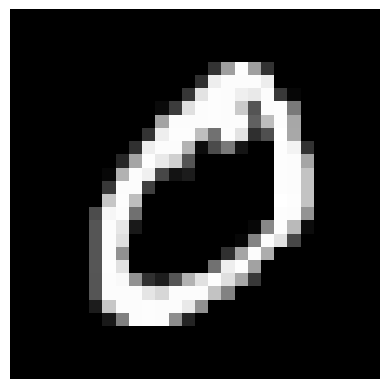

In [8]:
im0 = xb[1:2,:]  # image of a zero, shape is (1,1,28,28)
show_image(im0[0,0])

<Axes: >

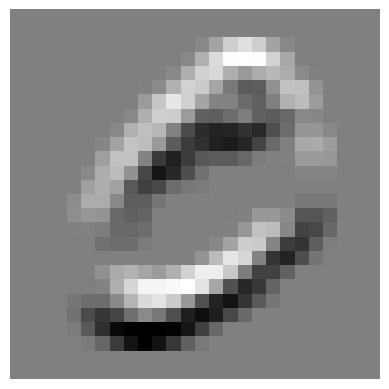

In [9]:
unfolded =F.unfold(im0 , (3,3))
conv = (unfolded[0].T@top_edge.view(-1)).view(26,26)
show_image(conv)

Fortunately we can just use `F.conv2d` from pytorch:  

In [12]:
im0.shape

torch.Size([1, 1, 28, 28])

<Axes: >

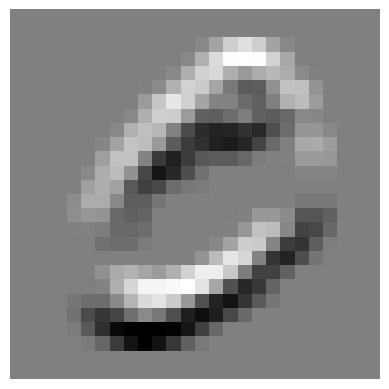

In [13]:
show_image(F.conv2d(im0, top_edge[None,None,:,:])[0,0])

In [14]:
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [15]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

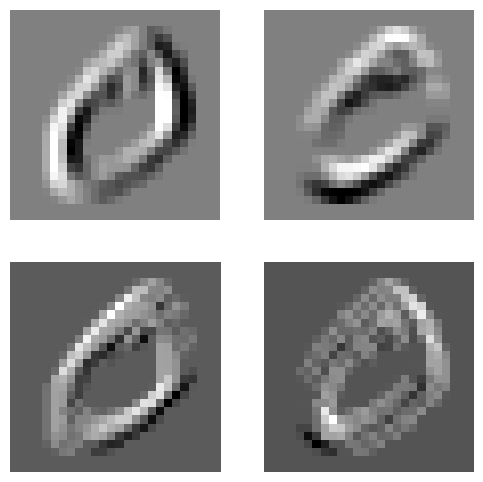

In [16]:
show_images(batch_features[1,:])

Now we have 4 channels, one for each kernel.

### Strides and Padding. 

* padding - adding pixels (set to zero) around the edge of the image. If the kernal size `ks` is odd, then we can add `ks//2` pixels to each side, this will keep the output the same size as the input.  (even numbered kernals are not used often because odd numbered are easier to work with and are centered on a pixel.)

* stride - how many pixels we move over each time we apply the kernel. Having a stride > 1 will reduce the size of the output. If you have padding of `ks//2` and stride of 2 we will reduce the input by half.

* The example we did used a 'stride' of   1 and no padding.  That is it moved over one pixel at a time, and the output got smaller as a result. 


## Creating the CNN

In [17]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [18]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),  # 1 input, 30 output 
    nn.ReLU(), 
    nn.Conv2d(30,10, kernel_size=3, padding=1)  # 30 intput, 10 output right.. done right?
)
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

We have not reduced the image size, 'output'channels here are per pixel.  

We want 10 output channels so we want bs (16) x 10 as the output.  We can to use stride 2 to reduce the image repeatably until we get to 1x1 image.   Lets define a simple function to keep this easier to read.

In [19]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Default stride, ks and padding will reduce the image size by half each time. 

In [20]:
simple_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4  
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten(),  # get rid of the 1x1 grid
)

In [21]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [23]:
x_train.shape

torch.Size([50000, 784])

In [22]:
x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds,valid_ds = Dataset(x_imgs, y_train),Dataset(xv_imgs, y_valid)

* def_device will detect what device we have, and we can use this constant to move the date model, etc to the device


* MPS (Metal Performance Shaders) is for mac Metal framework for GPU. I have not tested this... anyone have any experience?   Youtube video: [Run Pytorch , TensorFlow, and Jax on Mac](https://www.youtube.com/watch?v=cGEIEnekmRM)

In [24]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [25]:
from torch import optim

bs = 256
lr = 0.4
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [26]:
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.4552476325035095 0.8604000003814697
1 0.17889571833610535 0.9443000007629394
2 0.23400762515068055 0.9315999996185302
3 0.11043981952667237 0.9678999995231629
4 0.11551224484443665 0.9670999995231628


In [25]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4) # reduce learning rate, and train some more
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08848756594657899 0.9733000007629394
1 0.0853047025680542 0.9750000005722046
2 0.0862477997303009 0.9741999992370606
3 0.08696918740272522 0.9743999992370606
4 0.08576124382019043 0.9740999992370606


### Convolution arithmetic

The input is shape is refered to as NCWH ("channels first"). N is the batch size, C is the number of channels, W is the width of the image, H is the height of the image.  (Tensorflow uses NHWC "channels last") 


This section uses excel to illustrate the math of the convolution and the receptive field. Again we did this already in lesson 8, so i am not goint to revisit this repeat.

Key takeaways
  * We need a kernal for each input channel each output channel.  So if we have 3 input channels and 10 output channels, we need 30 kernals! Note the the ouput of the 30 kernals is summed over the input channels to get the output for each output channel.
  * For *color* images we start with 3 input channels. That is the only diference. 
  * The receptive field is the area of the input that affects a given output pixel.  The receptive field grows as we go deeper into the network. (This might be new, not sure if we covered it before)
  * Max pooling is another way to reduce the grid size instead of strides. ("out of fashion")

Example, the second layer had 4 input channels and 8 output channels:

In [26]:
[l.shape for l in simple_cnn[1].parameters()]

[torch.Size([8, 4, 3, 3]), torch.Size([8])]

## Autoencoders 
56 minute mark.

[08_autoencoder.ipynb](https://github.com/fastai/course22p2/blob/master/nbs/08_autoencoder.ipynb)

Set up

In [27]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from minai.datasets import *
from minai.training import *
from minai.conv import *


In [28]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

### Data

* Fashion MNIST, as in previous lesson

In [29]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)  # no `ignore verification` option as in video

In [30]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

bs = 256
tds = dsd.with_transform(transformi)

<Axes: >

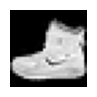

In [31]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1))

Recall our special 'collate_dict' 

In [32]:
cf = collate_dict(ds)

# move to device
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, b, **kwargs) : return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

dls = data_loaders(tds, bs, collate_fn=collate_)

dt = dls['train']
dv = dls['test']


In [33]:

xb, yb = next(iter(dt))

labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [34]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)


In [35]:

yb[:16]

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])

In [36]:
np.array(labels)[yb[:16]]    # equivalent 
[labels[i] for i in yb[:16]] # equivalent

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'T - shirt / top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot']

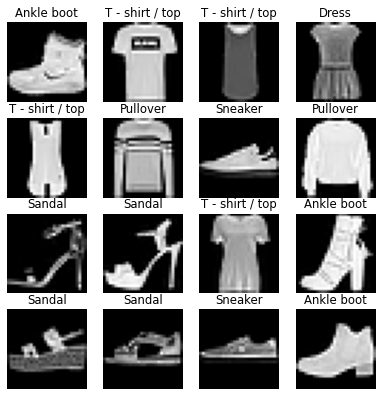

In [38]:


mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)


### Warmup - classify (just as above)

In [39]:
from torch import optim

bs = 256
lr = 0.4

cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

dsd['train'][0]

0 0.814637946510315 0.6968
1 0.5590271398067475 0.7946
2 0.4842389631271362 0.8253
3 0.4752382794380188 0.8306
4 0.44640288095474245 0.8386


{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

Jeremy mentions an issue with the images being PIL images, but these are already converted before training. We use teh DLS not DSD:

In [40]:
[type(o) for o in next(iter(dls['train']))]

[torch.Tensor, torch.Tensor]

In [41]:
cnn(xb)[0]

tensor([-6.49, -5.27, -8.96, -1.88, -4.61,  4.80, -6.15,  9.25,  4.15, 13.82], grad_fn=<SelectBackward0>)

#### Issues

* Discussion of issues with multiprocessing and the Dataloader. Using num_workers = 8 for example is incompatible with the dictionary collator. So we would need to rewrite our fit function. 
* Papers with code leaderboard : [Fashion MNIST](https://paperswithcode.com/sota/image-classification-on-fashion-mnist) shows bestbest accuracy is 96%.   So 83% is not good. 
* We will put all this aside though and go on to the autoencoder.

### Autoencoder (1:05)

* The idea is to compress the image into a smaller representation, and then decompress it back to the original image.
* The 'labels' are the same as the input. (that is the 'auto' part of the name)
* The 'encoder' is the part that compresses the image. The 'decoder' is the part that decompresses it.
* To do an autoencoder, we are going to have to 'deconvolve' back from the compressed image. 
   * Transposed convolutions are another.  (Left as an exercise for the reader). 
   * Instead we will use upsampling by copying the pixels ('nearest neighbor upsampling') followed by a stride 1 convolution. 

In [43]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

# New fit function, basically copied but with eval pulled out.  The main difference is the loss needs to use xb for labels instead of yb
# Jeremy points out that it is ANNOYING to have to recreate a fit function.  We will fix this with a Learner class in a moment.

def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)   #AUTO loss
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)



Baby's first autoencoder:

In [44]:
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32  # this is to allow us to get down to 4x4 easily with 3x3 kernels
    conv(1,2),        #16x16
    conv(2,4),        #8x8
     conv(4,8),        #4x4
     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28    this is a crop
    nn.Sigmoid()
).to(def_device)

In [45]:
eval(ae, F.mse_loss, dv)

0 0.168


In [46]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.149
1 0.138
2 0.132
3 0.129
4 0.127


In [90]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.124
1 0.122
2 0.074
3 0.047
4 0.037


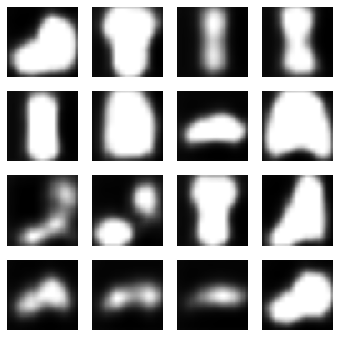

In [91]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

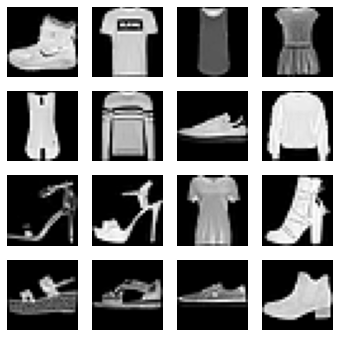

In [81]:
show_images(xb[:16].data.cpu(), imsize=1.5)

* This is not very good! 

* We can fiddle with it and make it better... 

In [93]:
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

opt = optim.Adam(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.016
1 0.015
2 0.014
3 0.014
4 0.014


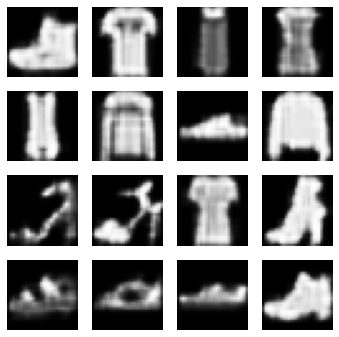

In [94]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

In [102]:
encoded_xb = (ae[0:3])(xb)
encoded_xb.shape

torch.Size([256, 4, 8, 8])

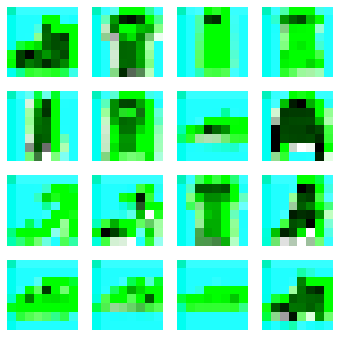

In [103]:
show_images(encoded_xb[:16].data.cpu(), imsize=1.5)


* Iterating manually like this is too slow
* We should automate this!

## Creating a Learner
1:15 mark

New notebook [09_learner.ipynb](https://github.com/fastai/course22p2/blob/master/nbs/09_learner.ipynb) .
 


### Set up again Fashion MNIST

In [48]:
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F


from fastprogress import progress_bar,master_bar


import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from minai.datasets import *
from minai.conv import *
import logging
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)


# Bring in the dataset again, as in last notebook.
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)



@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

bs = 1024
tds = dsd.with_transform(transformi)

#note we defined this in lesson 13, not using num_worker = 4 already

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

This Learner class is going to replace our fit function.  

Note that it is created from the model, the dataloders, the loss function, and the optimizer.  

* It includes a fit method that factors out the one_epoch function that can be called for training and valiation. 
* One epoch calls one_batch for each batch in the dataloader.
* Calc stats is used by one batch to calculate the loss and metric. *Currently* the metric is fixed as accuracy.
* It is not flexible enough yet, but we will fix that later.

In [2]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr() 
     # store_attr is a fastcore function that stores all the arguments in self

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [3]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.1753061197916668 0.5986166666666667
0 False 1.120378125 0.6133857142857143


### Metrics
Ok lets make it so we can configure the metric.  Each model will require a different metric, and we want this to be quite general so we can use it for any model.

As always, we do this by defining ... a class.

In [4]:
class Metric:
    def __init__(self): self.reset()

    def reset(self): self.vals,self.ns = [],[]

    def add(self, inp, targ=None, n=1):  # allows for minibatch processing
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)

    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    
    def calc(self, inps, targs): return inps


class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

# example
acc = Accuracy()
# add in batches 
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [5]:
loss = Metric() # can use metric directly for loss
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2) # same as weighted average using n.

(tensor(0.62), 0.62)

I think we wont actually be using these classes, as the notebook instead uses torcheval library

### Basic Callbacks Learner

We are now going to change our learner.   In addition to the metrics we want to add callbacks to the learner to do things like save the model, etc.  But most importantly we will use callbacks to allow us to change the metrics used. 

Define some custom exceptions we will need

In [49]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

# Superclass for callbacks . `order` is a class variable to allow for ordering of callbacks
class Callback(): order = 0

We will also define a decorrator (as a collable class) to enable adding callbacks to any function.  It will call the 'before' and 'after' methods of the callback with the name of the method.

The decorator will return a function that will call the original function, but wrap it with calls to 

In [7]:

class with_cbs:
    def __init__(self, nm): self.nm = nm # nm is the name of the callback
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}') # in use, 'o' will be self.
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

And here is the new Learner class, with callbacks and with no built in calc function, you have to use call backs for this.

In [12]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    # note in the notebook this is refactored to use a seperate helper functin.
    # this version is different also then the lecture, as I didnt feel the need to supply an identify function.
    def callback(self, method_nm): 
        for cb in sorted(self.cbs, key=attrgetter('order')): 
            method = getattr(cb, method_nm, None)
            if method is not None: method(self)

    
    @property
    def training(self): return self.model.training

These are not discussed in detail in this lecture, maybe they come back next week in a simpler contxt "Basic Callbacks Learner"

In [18]:
from torcheval.metrics import MulticlassAccuracy,Mean

# This class uses the torcheval.metrics interface which is a bit different then the Metric class we defined above and this was not yet covered in the course.
# The video used a slightly different version of the callbacks, which did not accept the addition learn parameter. I did not try to reconstruct it from 
# the video, but instead used the version from the notebook. 


In [10]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res
 

class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()
    
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    

In [10]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

accuray,loss,epoch,train
0.601,1.175,0,train
0.725,0.807,0,eval


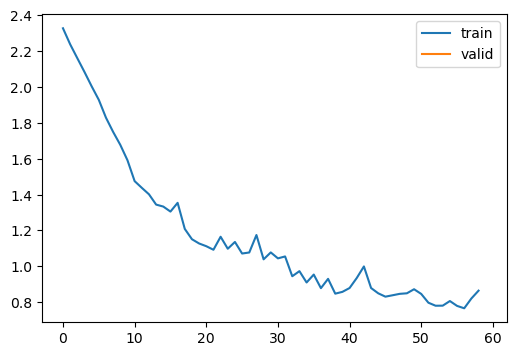

In [17]:
m, nh = 28*28, 50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
cbs = [DeviceCB(), TrainCB(), MetricsCB(accuray = MulticlassAccuracy()), ProgressCB(plot = True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

### Summary

* In this lesson the goal was simply to understand the concepts of using callbacks and metrics. 
* In the next lesson we will dig into this a bit more deeply.

# Python Recap

At the end he Recommends going back and digging into detail on the python code, expecially for things you are not familiar with. Use the debugger, etc. 